# Ensemble methods

In [51]:
import warnings
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from IPython.display import display

from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve, make_scorer, confusion_matrix, plot_roc_curve)

# Importing the cleaned data
df = pd.read_csv('stroke_clean.csv', index_col='id')
print('Dataset: ', df.shape)
df.head()

Dataset:  (4908, 18)


,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker,stroke
id,,,,,,,,,,,,,,,,,,
9046,0,67.0,0,1,1,1,228.69,36.6,0,0,1,0,0,0,1,0,0,1
31112,0,80.0,0,1,1,0,105.92,32.5,0,0,1,0,0,1,0,0,0,1
60182,1,49.0,0,0,1,1,171.23,34.4,0,0,1,0,0,0,0,1,0,1
1665,1,79.0,1,0,1,0,174.12,24.0,0,0,0,1,0,1,0,0,0,1
56669,0,81.0,0,0,1,1,186.21,29.0,0,0,1,0,0,0,1,0,0,1


In [2]:
# Do a train-test split
x = np.array(df.loc[:, df.columns != 'stroke'])
y = np.array(df['stroke'])
test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 41)

### Exploratory data analysis

After cleaning the data we do some quickly analysis of it to understand some of the underlying trends.

In [3]:
print("Number/percentage of stroke examples in dataset: ", df[df.stroke == 1].shape[0], df[df.stroke == 1].shape[0]/df.shape[0])
print("Number/percentage of non-stroke examples in dataset: ", df[df.stroke == 0].shape[0], df[df.stroke == 0].shape[0]/df.shape[0])
print()
print("Number/percentage of stroke examples in training set: ", x_train[y_train == 1].shape[0], x_train[y_train == 1].shape[0]/x_train.shape[0])
print("Number/percentage of non-stroke examples in training set: ", x_train[y_train == 0].shape[0], x_train[y_train == 0].shape[0]/x_train.shape[0])
print()
print("Number/percentage of stroke examples in test set: ", x_test[y_test == 1].shape[0], x_test[y_test == 1].shape[0]/x_test.shape[0])
print("Number/percentage of non-stroke examples in test set: ", x_test[y_test == 0].shape[0], x_test[y_test == 0].shape[0]/x_test.shape[0])

Number/percentage of stroke examples in dataset:  209 0.04258353708231459
Number/percentage of non-stroke examples in dataset:  4699 0.9574164629176855

Number/percentage of stroke examples in training set:  148 0.04308588064046579
Number/percentage of non-stroke examples in training set:  3287 0.9569141193595342

Number/percentage of stroke examples in test set:  61 0.041412084181941616
Number/percentage of non-stroke examples in test set:  1412 0.9585879158180584


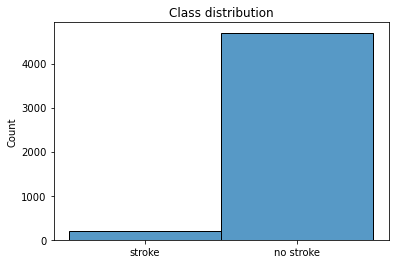

In [4]:
d = np.where(df.stroke == 1, "stroke", "no stroke")
sns.histplot(data = d).set_title("Class distribution")
plt.show()

We see that the class distribution is very skewed, which will make this a hard problem, as the model must be sensitive enough to capture the trends of the minority class.

Text(0.5, 1.0, 'Gender/stroke distribution')

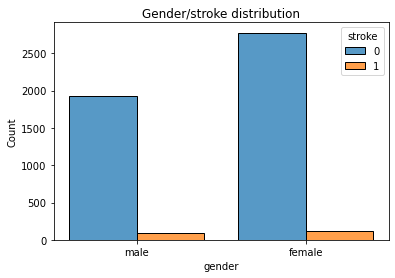

In [5]:
a = df.copy()
a.gender = np.where(df.gender == 1, "female", "male")
sns.histplot(data=a, x="gender", hue="stroke", multiple="dodge", shrink=.8).set_title("Gender/stroke distribution")

There are more female than male in the dataset, but the number of strokes between the two groups seems represenative for the group size.

Text(0.5, 1.0, 'Age/stroke distribution')

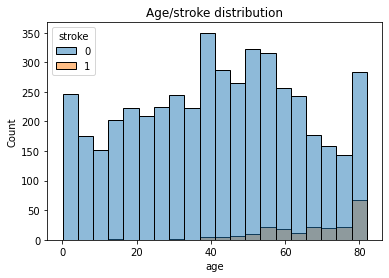

In [6]:
sns.histplot(data = df, x="age", hue="stroke").set_title("Age/stroke distribution")

We see that more old people than young people have strokes. It is not farfetched to assume that age will have an important role in the classification problem.

Text(0.5, 1.0, 'Bmi/stroke distribution')

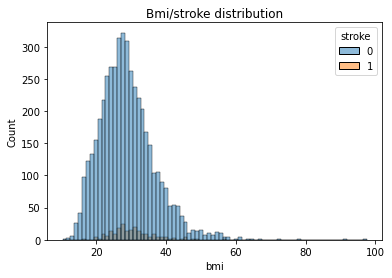

In [7]:
sns.histplot(data = df, x="bmi", hue="stroke").set_title("Bmi/stroke distribution")

Text(0.5, 1.0, 'Avg_glucaose_level/stroke distribution')

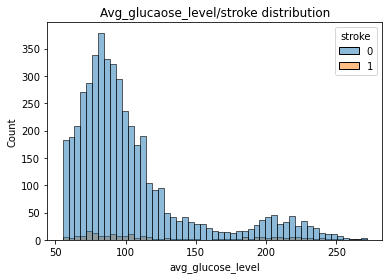

In [8]:
sns.histplot(data = df, x="avg_glucose_level", hue="stroke").set_title("Avg_glucaose_level/stroke distribution")

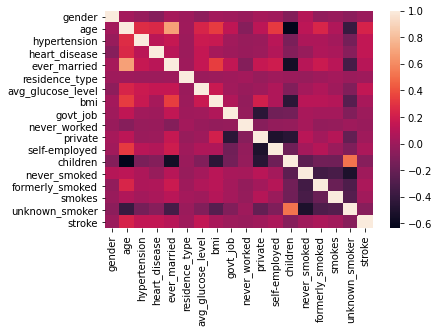

In [9]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix)
plt.show()

We see that the response stroke does not seems particularily correlated with any of the features. Thus the choice of non-linear models such as ensembles and neural networks is motivated.

In [10]:
# Necessary functions

def roc(model_fit, x_test, y_test):
    baseline_probs = [0 for _ in range(len(y_test))]
    probs = model_fit.predict_proba(x_test)[:, 1]

    # calculate scores
    baseline_auc = roc_auc_score(y_test, baseline_probs)
    pc_auc = roc_auc_score(y_test, probs)

    # calculate roc curves
    baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs, drop_intermediate = False)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print("Best Threshold=%f, G-Mean=%.3f" % (thresholds[ix], gmeans[ix]))
    a = np.where(probs >= thresholds[ix], 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, a).ravel()
    print("tn: ", tn)
    print("tp: ", tp)
    print("fn: ", fn)
    print("fp: ", fp)
    print("accuracy: ", accuracy_score(y_test, a))
    print("precision: ", precision_score(y_test, a))
    print("recall: ", recall_score(y_test, a))
    print("f1: ", f1_score(y_test, a))

    # plot the roc curve for the model
    plt.figure()
    plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", color = "lightgrey")
    plt.plot(fpr, tpr, marker = ".", label = "ROC AUC=%.3f" % (pc_auc), color = "orange")
    plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
def precision_recall(model_fit, x_test, y_test):
    probs = model_fit.predict_proba(x_test)[:, 1]
    
    # predict class values
    precision, recall, _ = precision_recall_curve(y_test, probs)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    yhat = model_fit.predict(x_test)
    model_f1, model_auc = f1_score(y_test, yhat), auc(recall, precision)
    
    # plot the precision-recall curves
    plt.figure()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color = "lightgray")
    plt.plot(recall, precision, marker=".", label="f1=%.3f auc=%.3f" % (model_f1, model_auc), color = "orange")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

def train_error(model_fit):
    train_pred = model_fit.predict(x_train)

    print("Train errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_train, train_pred))
    print("precision: %.3f" % precision_score(y_train, train_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_train, train_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_train, train_pred, zero_division = 0))
    print()
    
def test_error(model_fit):
    test_pred = model_fit.predict(x_test)

    print("Test errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_test, test_pred))
    print("precision: %.3f" % precision_score(y_test, test_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_test, test_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_test, test_pred, zero_division = 0))

    cm_test = confusion_matrix(y_test, test_pred)
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm_test.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm_test, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")

### How to evaluate performance?

In this binary classification problem we are dealing with a very imbalanced dataset. The majority class has 96% of the observations, while the minority class only has 4%. This is typical in medical datasets that deals with prediction of rare occurrences like stroke. We will always have many more examples of people without the condition, than with, making it very dificult to correctly identify the general pattern behind the minority class. In addition, with skewed medical datasets like this one, false negative rates and false positive rates do not have equal weight. In our dataset, a false negative will be much more dangerous than a false positive, as it is better to predict that someone will get a stroke and get it wrong, than the other way around.

For binary classification problems it is typical to use accuracy as the metric to evaluate performance of the method. Accuracy is the ratio of the correctly predicted observations to the total number of observation. With an imbalanced problem like the one we have, accuracy will not be a good preformance measure. To show why, if we simply make a classification model which predicts all observations as class 0, "no stroke", we will get a very high accuracy which will not reflect the difference in size between the two classes.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}} = \frac{4699 + 0}{4699 + 0 + 209 + 0} = 0.957
\end{align*}

Other measures which are better with dealing with unsymmetric classes are precision and recall. Precision is the ratio of correctly predicted positive observations to the total number of predicted positive observations. Precision favors a low false positive rate. Recall is the ratio of correctly predicted positive observations to all the observations in the actual class. This favors the false negative rate, which is important when we want to minimize the number of false negatives. Both of these metrics would becomes zero in the case above.

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}, \quad \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

To be able to take into account both recall and precision, we can use the f1-measure, which is the harmoic mean of precision and recall:

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Instead of using the predicted values from using the threshold 0.5, we could also calculate both ROC-AUC and precision-recall-AUC to find better thresholds. ROC-AUC is the area under the ROC curve which plots the true positive rate against the false positive rate. The precision-recall curve uses precision instead of false positive rate, and can be considered better in the case when we have an unproportional large amount of true negatives, since neither recall or precision takes this into account. We calculate the best threshold by the G-mean.

Sklearn also icludes several metric which tries to balance out the classes during evaluation. The balanced accuracy score is defined as the average of recall obtained on each class. Weighted F1 calculates precision and recall for each label and finds their average weighted by support. We choose to use the weighted F1.

### Hyperparameter tuning

To find the optimal hypoerparameters we will do a gridsearch over the gridspace spesified for each method, combined with a 5-fold cross-validation, such that the chosen hyperparameters does not make the model overfit the training data. We use the weighted F1 as the scorer to choose the optimal hyperparameters.

In [11]:
metric = "balanced_accuracy" # Tried: roc_auc, f1_weighted (best so far), balanced acc (actually best so far), recall

### Decision tree

We start by implementing a simple deicision tree to test the GrisSearhCV and get a baseline error. We will first implement the decision tree using "accuracy" as metrics to show that this does not yield the optimal results.

In [12]:
parameters = {"max_depth": range(1, 10, 1),          # The maximum depth of the tree
              "min_samples_split": range(2, 5, 1),   # The minimum number of samples required to split an internal node
              "min_samples_leaf": range(1, 10, 1)}   # The minimum number of samples required to be at a leaf node

clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 23, criterion = "gini"),
                   param_grid = parameters,
                   scoring = "accuracy",
                   cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_

print("Best hyperparameter from the gridsearch:")
print(best_params)

Best hyperparameter from the gridsearch:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


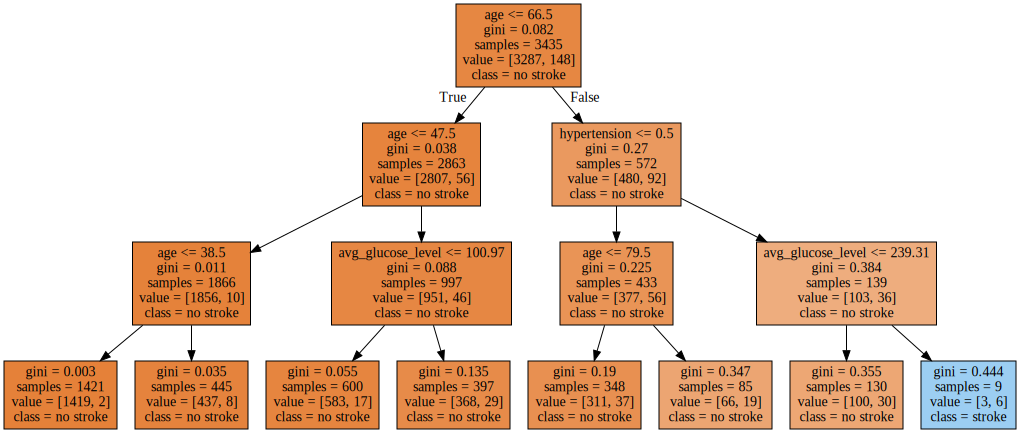

In [13]:
tree = DecisionTreeClassifier(**best_params, criterion = "gini", random_state = 23)
tree_fit = tree.fit(x_train, y_train)

display(graphviz.Source(export_graphviz(tree_fit, feature_names = df.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

Train errors:

accuracy: 0.958
precision: 0.667
recall: 0.041
f1: 0.076

Test errors:

accuracy: 0.958
precision: 0.000
recall: 0.000
f1: 0.000


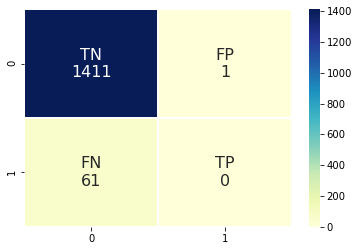

In [14]:
train_error(model_fit = tree_fit)
test_error(model_fit = tree_fit)

Best Threshold=0.073048, G-Mean=0.755
tn:  1022
tp:  48
fn:  13
fp:  390
accuracy:  0.7264086897488119
precision:  0.1095890410958904
recall:  0.7868852459016393
f1:  0.19238476953907815


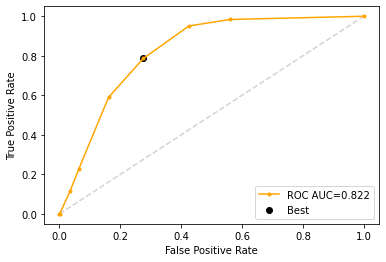

In [15]:
roc(model_fit = tree_fit, x_test = x_test, y_test = y_test)

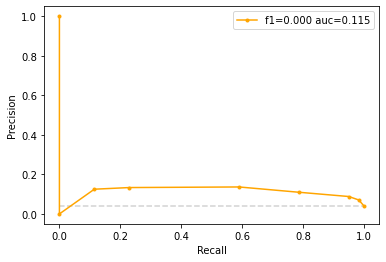

In [16]:
precision_recall(model_fit = tree_fit, x_test = x_test, y_test = y_test)

Use one of the other measures instead to get a better precision and recall on the test set. It is not good enough that all the negative examples are classified correctly. We would rather trade more false positive for less false negative.

Best hyperparameter from the gridsearch:
{'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 2}


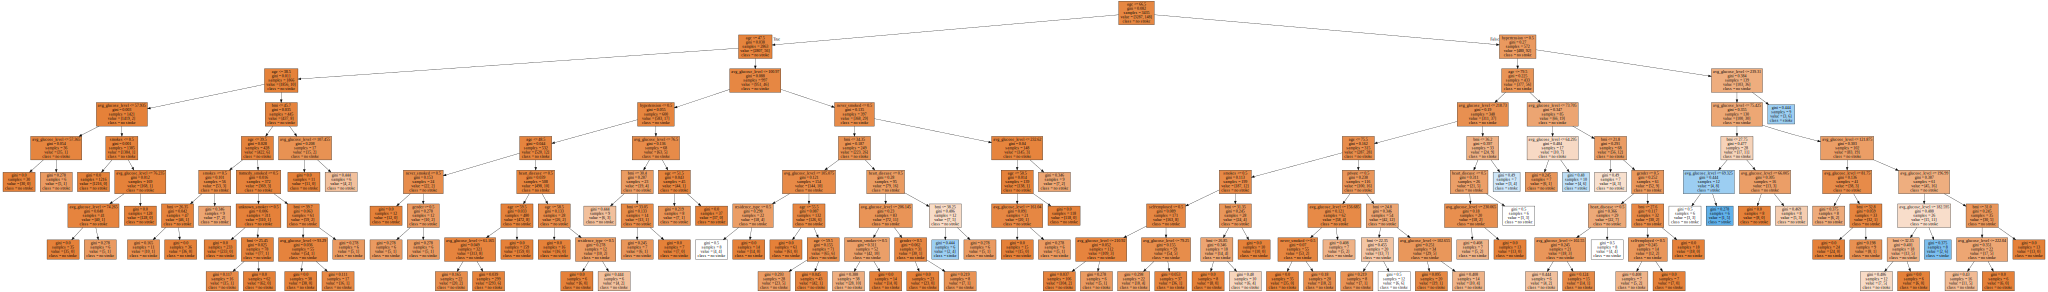

In [17]:
parameters = {"max_depth": range(1, 10, 1),          # The maximum depth of the tree
              "min_samples_split": range(2, 5, 1),   # The minimum number of samples required to split an internal node
              "min_samples_leaf": range(1, 10, 1)}   # The minimum number of samples required to be at a leaf node

clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 23, criterion = "gini"),
                   param_grid = parameters,
                   scoring = metric,
                   cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_

print("Best hyperparameter from the gridsearch:")
print(best_params)

tree = DecisionTreeClassifier(**best_params, criterion = "gini", random_state = 23)
tree_fit = tree.fit(x_train, y_train)

display(graphviz.Source(export_graphviz(tree_fit, feature_names = df.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

Train errors:

accuracy: 0.962
precision: 0.674
recall: 0.209
f1: 0.320

Test errors:

accuracy: 0.948
precision: 0.100
recall: 0.033
f1: 0.049


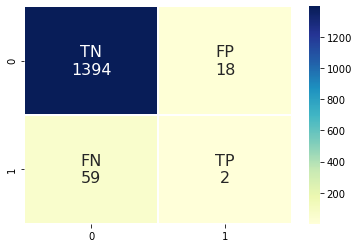

In [18]:
train_error(model_fit = tree_fit)
test_error(model_fit = tree_fit)

Best Threshold=0.018868, G-Mean=0.673
tn:  1001
tp:  39
fn:  22
fp:  411
accuracy:  0.7060420909708078
precision:  0.08666666666666667
recall:  0.639344262295082
f1:  0.15264187866927595


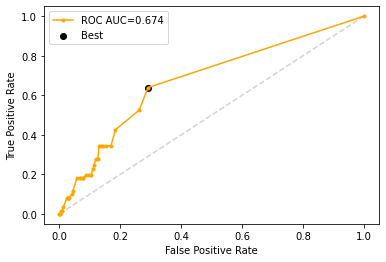

In [19]:
roc(model_fit = tree_fit, x_test = x_test, y_test = y_test)

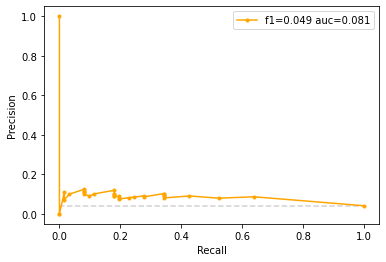

In [20]:
precision_recall(model_fit = tree_fit, x_test = x_test, y_test = y_test)

### Random Forest

Try to fit a random forest model to the stroke classification problem. Use cross-validation grid search to find the optimal parameters.

Wy does not random forest work properly? Since we have som few stroke examples, it is hard to find a shallow tree which manages to predict anything other than the majority class. In addition, during the bootstrap preocedure, we expect even fewer examples from the minority classs to be present during the fitting of the model. This is why the model fails, and would rather build one deep tree to find the minoriy examples. There is no use bildign more than 1 such tree, as they do not have that much variance between them. This motives the use for better sampling during the bootstrap which leads to weighted random forest and balanced random forest.

In [21]:
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [10, 30, 50, 100],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 23,
                                                      criterion = 'gini',
                                                      bootstrap = True),
                  param_grid = parameters,
                  scoring = metric,
                  cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print("Best hyperparameter from the cv-gridsearch:")
print(best_params)

warnings.filterwarnings('always')

Best hyperparameter from the cv-gridsearch:
{'max_depth': 9, 'max_features': 8, 'n_estimators': 10}


Train errors:

accuracy: 0.974
precision: 1.000
recall: 0.399
f1: 0.570

Test errors:

accuracy: 0.957
precision: 0.286
recall: 0.033
f1: 0.059


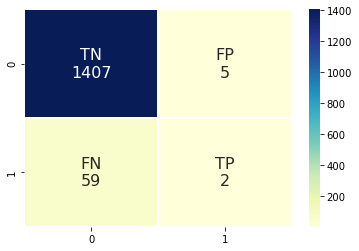

In [22]:
rf = RandomForestClassifier(**best_params, random_state = 23, criterion = "gini", bootstrap = True)
rf_fit = rf.fit(x_train, y_train)

train_error(model_fit = rf_fit)
test_error(model_fit = rf_fit)

Best Threshold=0.013844, G-Mean=0.745
tn:  903
tp:  53
fn:  8
fp:  509
accuracy:  0.6490156143923965
precision:  0.09430604982206406
recall:  0.8688524590163934
f1:  0.17014446227929375


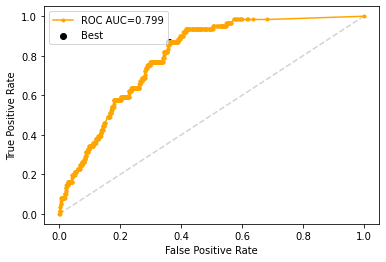

In [23]:
roc(model_fit = rf_fit, x_test = x_test, y_test = y_test)

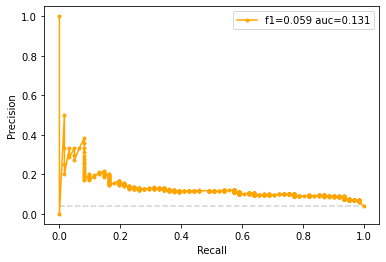

In [24]:
precision_recall(model_fit = rf_fit, x_test = x_test, y_test = y_test)

### Weighted Random Forest

Try a weighted random forest to even out the imbalanced classes. The weighted random forest works bu changing the weight the each class has when calculating the impurity score at each split. When the data has a skewed class distribution the impurity calculating becomes biased such that false negatives for the majority class is permitted.

From using random forest to learn imbalanced data: Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty on misclassifying the minority class.

In python this can easily be achieved by using argument "class_weight". The value "balanced" uses the inverse weighting from the training dataset, giving focus to the minority class. Using the value "balanced_subsample" instead, the class weighting changes based on the class distribution in each bootstrap sample, instead of the entire dataset. As we expect the bootstrap samples to contain even fewer classifications of stroke, we use the "balance_subsample value" when training the weighted random forest.

In [25]:
np.random.seed(41)
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [5, 10, 30, 50, 100],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 23,
                                                      criterion = 'gini',
                                                      class_weight = 'balanced_subsample',
                                                      bootstrap = True,
                                                      oob_score = False),
                  param_grid = parameters,
                  scoring = metric,
                  cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print("Best hyperparameter from the cv-gridsearch:")
print(best_params)

warnings.filterwarnings('always')

Best hyperparameter from the cv-gridsearch:
{'max_depth': 4, 'max_features': 8, 'n_estimators': 100}


Train errors:

accuracy: 0.794
precision: 0.153
recall: 0.838
f1: 0.259

Test errors:

accuracy: 0.766
precision: 0.119
recall: 0.721
f1: 0.204


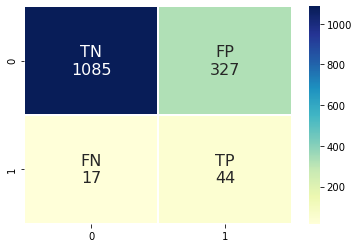

In [26]:
wrf = RandomForestClassifier(**best_params, class_weight = "balanced_subsample")
wrf_fit = wrf.fit(x_train, y_train)

train_error(model_fit = wrf_fit)
test_error(model_fit = wrf_fit)

Best Threshold=0.456975, G-Mean=0.766
tn:  1032
tp:  49
fn:  12
fp:  380
accuracy:  0.7338764426340801
precision:  0.11421911421911422
recall:  0.8032786885245902
f1:  0.2


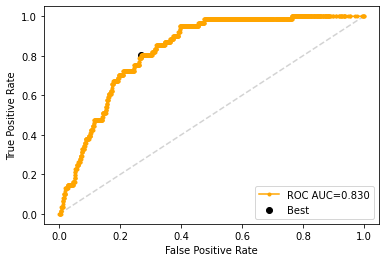

In [27]:
roc(model_fit = wrf_fit, x_test = x_test, y_test = y_test)

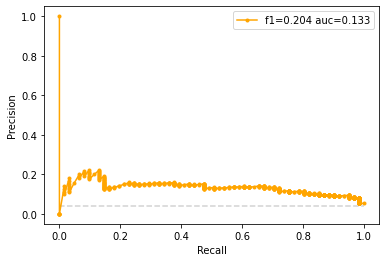

In [28]:
precision_recall(model_fit = wrf_fit, x_test = x_test, y_test = y_test)

### Balanced Random Forest

We get a small improvement in the wrf compared to the rf. An even bigger improvement can be made if we use the Balanced Random Forest. The method works by randomly undersampling from the majority class during the bootstrap sampling.  

The implementation of the BRF is from a python library called imbalanced-learn which offers a number of resampling techniques commenyl used in datasets showing strong between-class imbalance: https://pypi.org/project/imbalanced-learn/.

In [29]:
parameters = {'n_estimators': [5, 10, 30, 50],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = BalancedRandomForestClassifier(random_state = 23,
                                                              criterion = 'gini',
                                                              class_weight = 'balanced_subsample',
                                                              bootstrap = True,
                                                              oob_score = False),
                  param_grid = parameters,
                  scoring = metric,
                  cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

{'max_depth': 9, 'max_features': 8, 'n_estimators': 50}


Train errors:

accuracy: 0.760
precision: 0.152
recall: 1.000
f1: 0.265

Test errors:

accuracy: 0.731
precision: 0.108
recall: 0.754
f1: 0.189


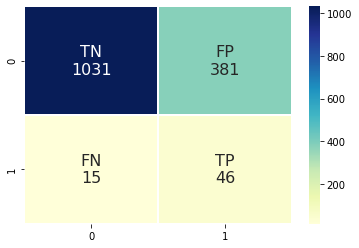

In [30]:
brf = BalancedRandomForestClassifier(**best_params, class_weight = 'balanced_subsample')
brf_fit = brf.fit(x_train, y_train)

train_error(model_fit = brf_fit)
test_error(model_fit = brf_fit)

Best Threshold=0.457880, G-Mean=0.776
tn:  998
tp:  52
fn:  9
fp:  414
accuracy:  0.7128309572301426
precision:  0.11158798283261803
recall:  0.8524590163934426
f1:  0.19734345351043645


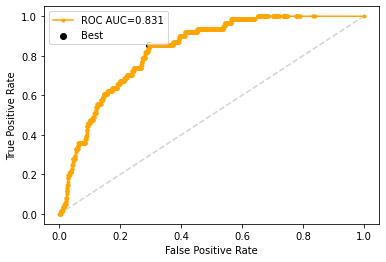

In [31]:
roc(model_fit = brf_fit, x_test = x_test, y_test = y_test)

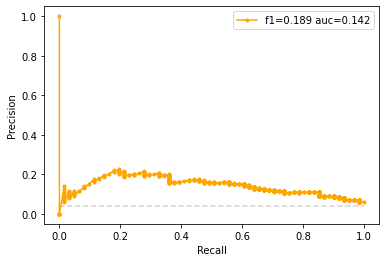

In [32]:
precision_recall(model_fit = brf_fit, x_test = x_test, y_test = y_test)

### XgBoost

Try to implement XGBoost to make performance better.

In [33]:
parameters = {'n_estimators': [10, 50, 100],
              'eta': [0, 0.2, 0.4],
              'gamma': [0],
              #'reg_lambda': range(1, 5, 1),
              #'reg_alpha': range(0, 5, 1),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = xgb.XGBClassifier(random_state = 23, booster = "gbtree", objective = "binary:logistic",
                                                use_label_encoder = False, eval_metric = "logloss"),
                   param_grid = parameters,
                   scoring = metric,
                   cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

{'eta': 0.4, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100}


Train errors:

accuracy: 0.975
precision: 1.000
recall: 0.426
f1: 0.597

Test errors:

accuracy: 0.948
precision: 0.059
recall: 0.016
f1: 0.026


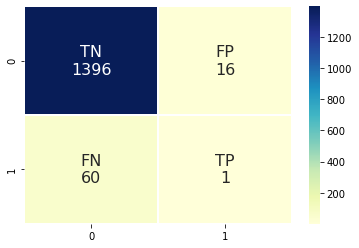

In [34]:
xgb_model = xgb.XGBClassifier(**best_params, random_state = 23, booster = "gbtree", objective = "binary:logistic",
                             use_label_encoder = False, eval_metric = "logloss")
xgb_fit = xgb_model.fit(x_train, y_train)

train_error(model_fit = xgb_fit)
test_error(model_fit = xgb_fit)

### Interpreting the results: XAI

Which packages do we need to do this? pdpbox, alepython, lime...

Global methods:
* Linear model (standardized coeffs, shapley regression)
* XGBoost/RF (gini importance)
* Partial dependence plots
* ALE plots

Local methods:
* LIME
* Shapley
* Counterfactual explanations

Links:
* https://machinelearningmastery.com/feature‐importance‐and‐feature‐selection‐with‐xgboost‐in‐python/

#### Global methods

Use the gini importance and look at some partial dependence plots for the most important features.

In [35]:
# Importance of each feature
pd.DataFrame(brf.feature_importances_.reshape(1, -1), columns=df.columns[:-1])

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker
0,0.016405,0.435115,0.033648,0.017771,0.033041,0.018427,0.183733,0.149654,0.012049,0.0,0.009884,0.016559,0.000608,0.022065,0.019784,0.019052,0.012203


Most important features for brf: age, avg_glucose_level, bmi

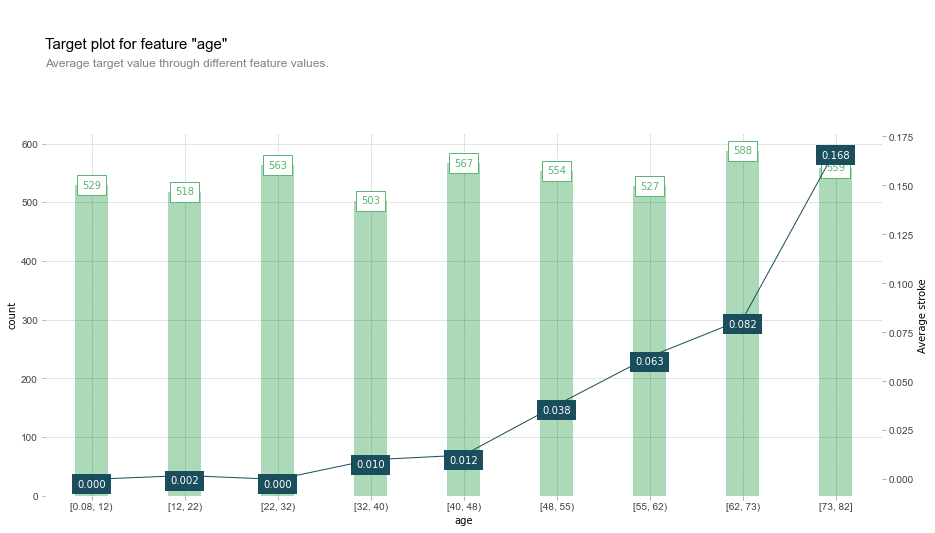

In [36]:
# Age

fig, axes, summary = info_plots.target_plot(df = df, feature = "age", feature_name = "age", target = "stroke")

In [37]:
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'residence_type',
            'avg_glucose_level', 'bmi', 'govt_job', 'never_worked', 'private', 'self-employed',
            'children', 'never_smoked', 'formerly_smoked', 'smokes', 'unknown_smoker']

C:\Users\elveb\Anaconda3\lib\site-packages\pdpbox\info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]


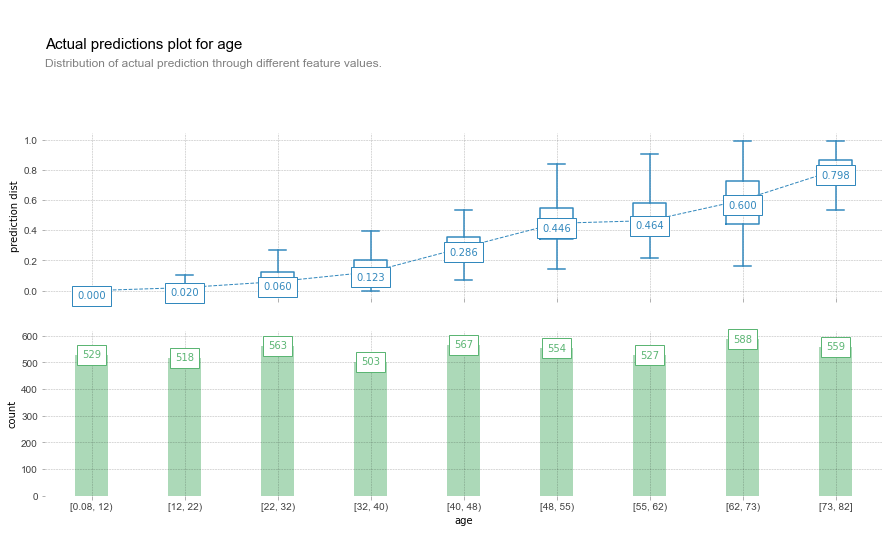

In [38]:
fig, axes, summary = info_plots.actual_plot(model=brf, X=df[features], feature='age', feature_name='age')

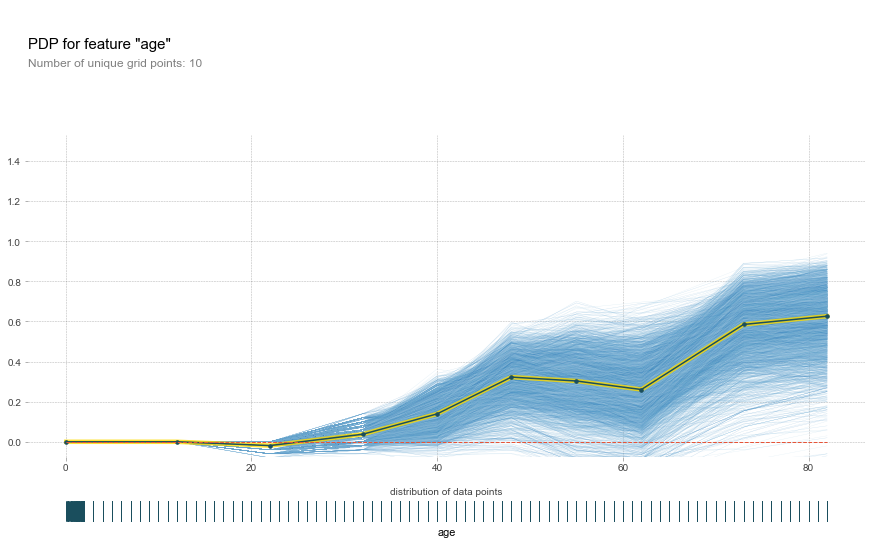

In [39]:
pdp_age = pdp.pdp_isolate(
    model=brf, dataset=df, model_features=features, feature="age"
)

fig, axes = pdp.pdp_plot(pdp_age, "age", plot_lines=True, plot_pts_dist=True)

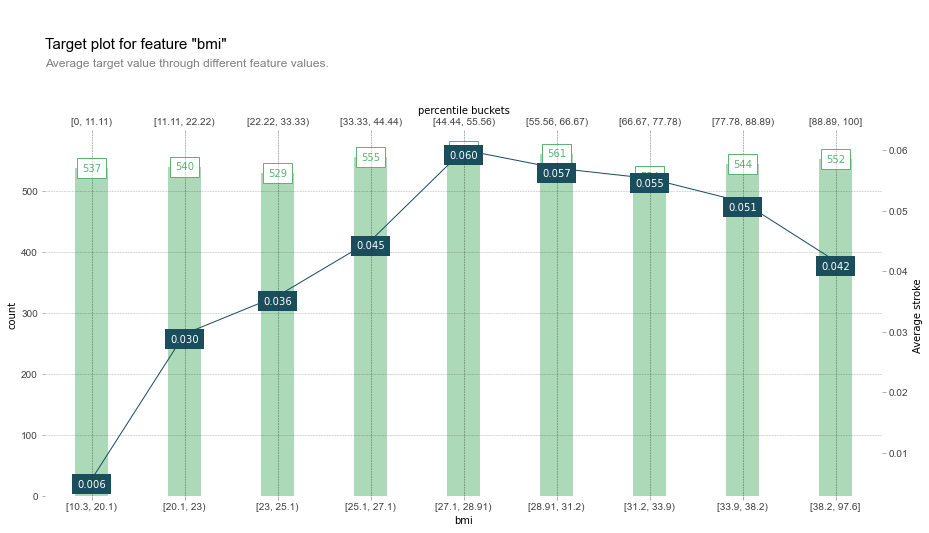

In [40]:
# BMI

fig, axes, summary_df = info_plots.target_plot(
    df=df, feature='bmi', feature_name='bmi', target='stroke', show_percentile=True
)

C:\Users\elveb\Anaconda3\lib\site-packages\pdpbox\info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]


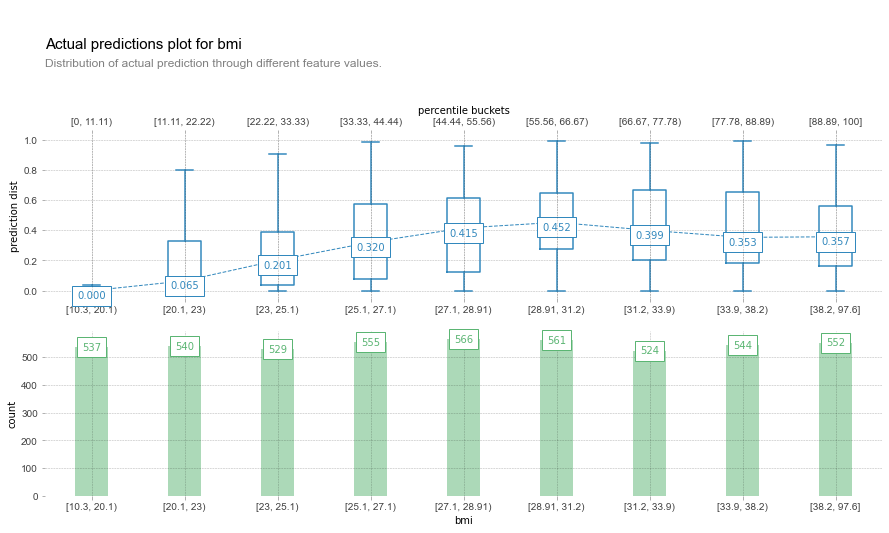

In [41]:
fig, axes, summary_df = info_plots.actual_plot(
    model=brf, X=df[features], feature='bmi', feature_name='bmi', 
    show_percentile=True
)

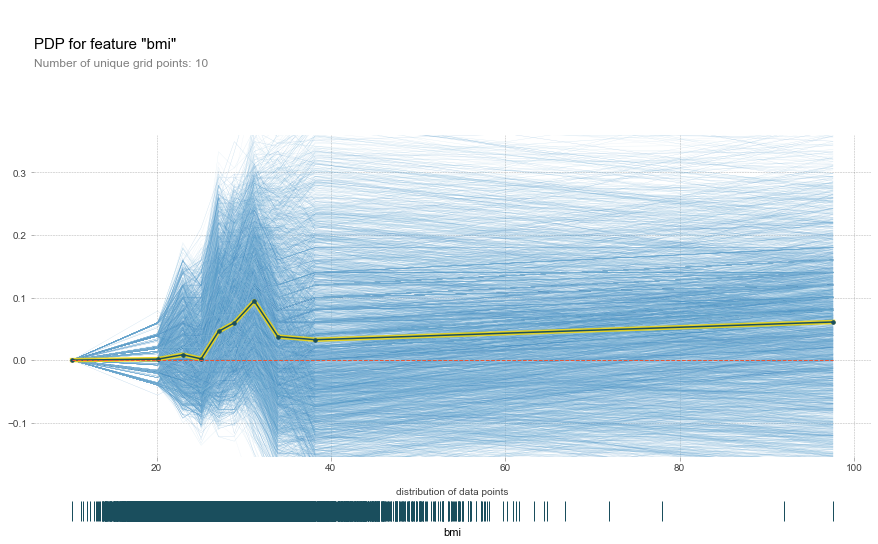

In [42]:
pdp_bmi = pdp.pdp_isolate(
    model=brf, dataset=df, model_features=features, feature="bmi"
)

fig, axes = pdp.pdp_plot(pdp_bmi, "bmi", plot_lines=True, plot_pts_dist=True)

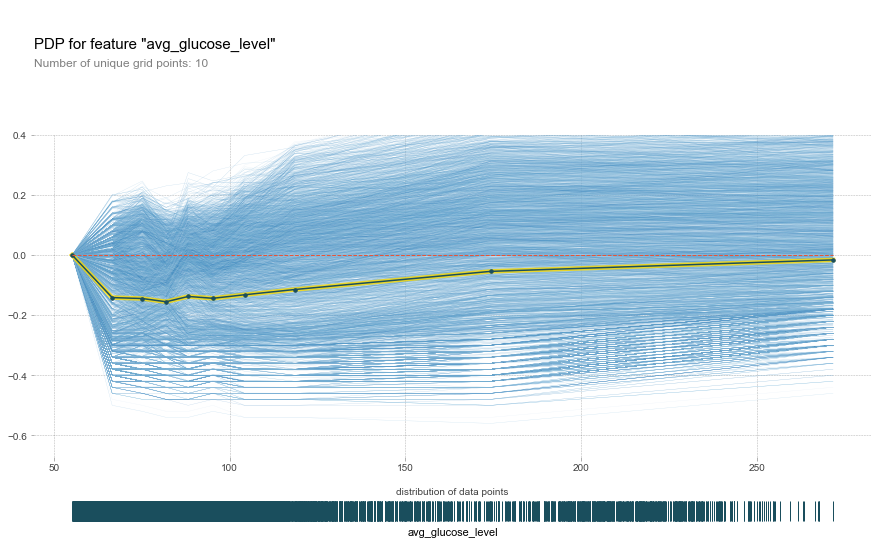

In [43]:
# Avg_glucose_levels

pdp_glucose = pdp.pdp_isolate(
    model=brf, dataset=df, model_features=features, feature="avg_glucose_level"
)

fig, axes = pdp.pdp_plot(pdp_glucose, "avg_glucose_level", plot_lines=True, plot_pts_dist=True)

#### Local methods

Use lime, counterfactual and shapley values to explain some datapoints. Choose 4 datapoints. One tn, one tp, one fn, and one fp for the model we are looking at. Look at the lime plots and explain the behavior.

Observation 100: stroke, predicted correctly by brf

Observation 99: no stroke, not predicted correctly by brf. Why? Seems to put too mcuh weight on age and hypertension

Observation 50: no stroke, predicted correctly by brf

Observation 191: stroke, not predicted correctly by the brf. Why? Seems like it puts too much weight on hypertension

In [60]:
explainer = LimeTabularExplainer(training_data = x_train,
                                 training_labels = y_train,
                                 feature_names = features,
                                 class_names = "stroke",
                                 mode = "classification")
                                 #discretize_continuous = True)

In [72]:
i = 191
    
obs = x_test[i]
true_class = y_test[i]

print("Observation: ", obs)
print("True class: ", true_class)
print("Predicted probabilities: ", brf.predict_proba(x_test)[i])

Observation:  [ 1.   46.    0.    0.    1.    1.   78.18 30.8   0.    0.    1.    0.
  0.    1.    0.    0.    0.  ]
True class:  1
Predicted probabilities:  [0.77763045 0.22236955]


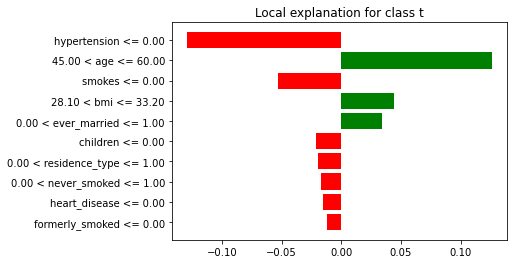

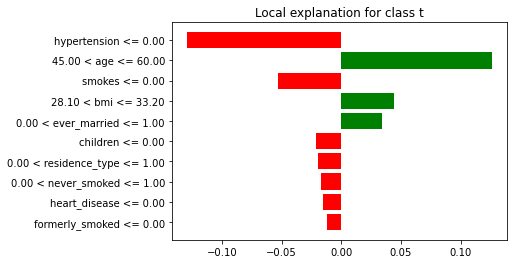

In [73]:
exp = explainer.explain_instance(obs, brf.predict_proba)
exp.as_pyplot_figure()